In [1]:
import os
import re
import json
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import wraps

In [2]:
%matplotlib inline

In [3]:
def collect_results(result_dir, param_dir, result_type='gB1', param_name=None):
    xs = []
    ys = []
    for filename in sorted(list(os.listdir(result_dir))):
        val = 0.0
        filepath = os.path.join(result_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                val = float(line.strip())
                break
        ys.append(val)

        name_part, ext = os.path.splitext(filename)
        param_filename = f'{name_part}.json'
        filepath = os.path.join(param_dir, param_filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if result_type == 'gB1':
                x = data['pulseseq']['components']['emr2']['e']['frequency']/1e6
                xs.append(float(x))
            elif result_type == 'length':
                x = data['pulseseq']['sections'][param_name]['size']
                xs.append(float(x))
            elif result_type == 'fp':
                x = data['settings']['Magnet']['b0']
                xs.append(float(x))
            else:
                raise NotImplementedError
    return xs, ys

In [4]:
eofe_results_root = 'outputs/eofe_outputs'
eofe_params_root = 'inputs/eofe_inputs'
def get_xy_from_collection(collection_name, eofe_res_dir, result_type):
    res_dir = os.path.join(eofe_res_dir, collection_name, f'{collection_name}_results')
    param_dir = os.path.join(eofe_res_dir, collection_name, collection_name)
    xs, ys = collect_results(res_dir, param_dir, result_type)
    return xs, ys

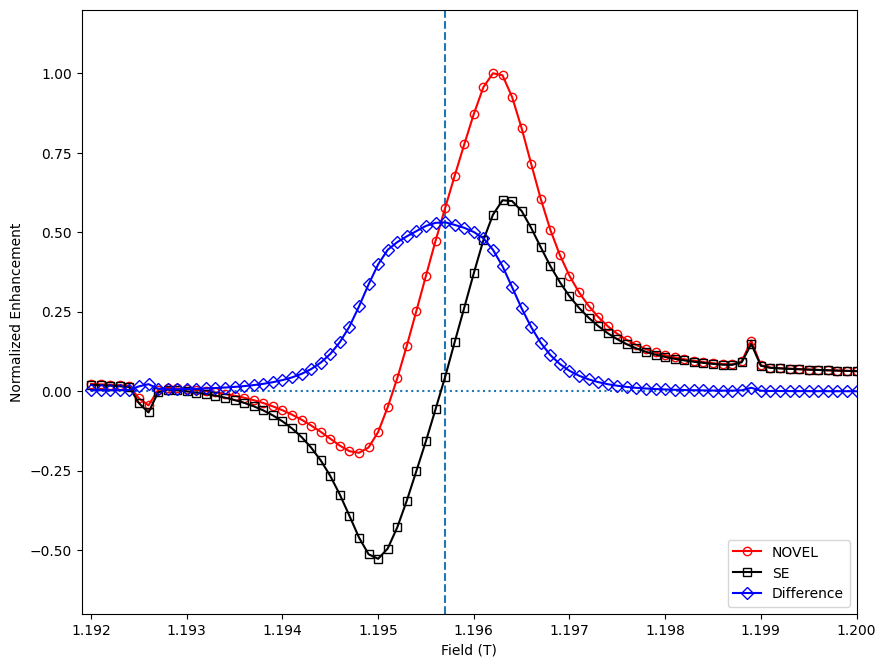

In [5]:
idx=74
loop=200

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_ref_inc0p1'
xs_ref, ys_ref = get_xy_from_collection(collection_name, eofe_results_root, 'fp')

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_inc0p1'
xs_novel, ys_novel = get_xy_from_collection(collection_name, eofe_results_root, 'fp')

collection_name = f'qband_p{idx}_flip1_mix20k_d200k_loop{loop}_fp_se_inc0p1'
xs_se, ys_se = get_xy_from_collection(collection_name, eofe_results_root, 'fp')


ys1 = np.array(ys_novel)/np.array(ys_ref)
ys2 = np.array(ys_se)/np.array(ys_ref)

factor = np.max(ys1)

fig = plt.figure(figsize=(10, 8), dpi=100)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)

ax1.plot(xs_ref, ys1/factor, marker='o', linestyle='solid', color='r', markerfacecolor='none', label='NOVEL')
ax1.plot(xs_ref, ys2/factor, marker='s', linestyle='solid', color='k', markerfacecolor='none', label='SE')

ys_diff = np.array(ys1) - np.array(ys2)
ax1.plot(xs_se, ys_diff/factor, marker='D', linestyle='solid', color='blue', markerfacecolor='none', label='Difference')

ax1.vlines(1.1957, -0.7, 1.2, linestyle='dashed')
ax1.hlines(0, np.min(xs_ref), np.max(xs_ref), linestyle='dotted')

ax1.legend(loc='lower right')
plt.xlabel('Field (T)')
ax1.set_ylabel('Normalized Enhancement')
plt.ylim(-0.7, 1.2)
plt.xlim(1.1919, 1.20)
# plt.savefig('cody_figure3_fp_simulation_v3.ps')
plt.show()

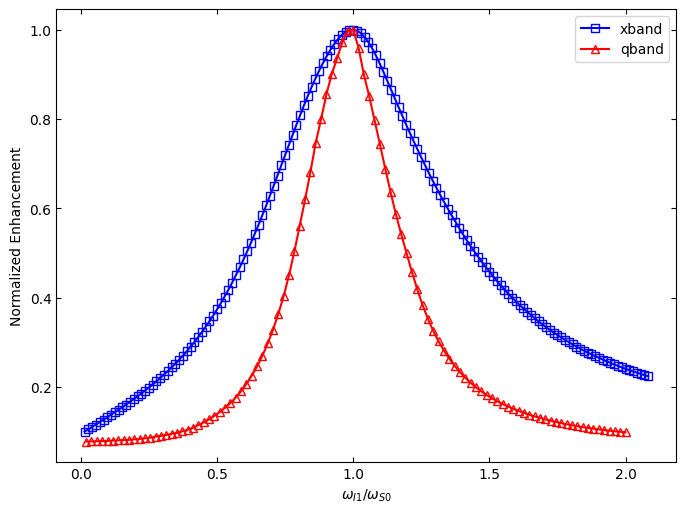

In [6]:
idx=74
loop2=200

# Cody 1.2T Simulation data

# DNPSOUP figure data & Cody 1.2T Simulation data
collection_name = f'xband_p83_flip16_mix500_d100k_loop{loop2}_scan_gB1_inc1'
xs_x2, ys_x2 = get_xy_from_collection(collection_name, eofe_results_root, 'gB1')

# Cody 1.2 T simulation data
collection_name = f'qband_p74_flip1_mix20k_d200k_loop200_scan_gB1_inc0p1'
# collection_name = f'qband_p83_flip5_mix500_d100k_loop{loop2}_scan_gB1_inc1'
xs_q, ys_q = get_xy_from_collection(collection_name, eofe_results_root, 'gB1')

fig = plt.figure(figsize=(8, 6), dpi=100)
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1)

ax1.plot(np.array(xs_x2)/xs_x2[np.argmax(ys_x2)], ys_x2/np.max(ys_x2), 
         marker='s', linestyle='solid', color='blue', markerfacecolor='none', label='xband')
ax1.plot(np.array(xs_q)/xs_q[np.argmax(ys_q)], ys_q/np.max(ys_q), marker='^', linestyle='solid', color='r', markerfacecolor='none', label='qband')

ax1.legend(loc='upper right')
ax1.set_xlabel('$\omega_{I1}/\omega_{S0}$')
ax1.set_ylabel('Normalized Enhancement')
ax1.tick_params(
    direction='in',
    bottom=True,
    top=True,
    left=True,
    right=True
)
plt.show()